# The Patent Application Table (`TLS201_APPLN`)

Welcome to this look at one of the most fundamental tables in the PATSTAT database: the **Application Table**, designated as `TLS201_APPLN`. As we dive into this table, we will uncover what each field means in the context of the patent application process. This table serves as the foundation of patent data because it captures information about the patent applications themselves, which are the formal requests for patent protection.

## What is a Patent Application?

A **patent application** is a legal document filed by an inventor (or the inventor’s representative) to a patent office, requesting protection for a new invention. The application includes technical details about the invention and explains how it meets the requirements for a patent (such as novelty and inventiveness). The application is the **first step** in obtaining patent protection. However, the mere filing of an application does not guarantee that a patent will be granted—there are several steps in between.

Now, let’s break down the key fields in this table and how they relate to the process of patenting. We need to initialize the PATSTAT client, and import the applications table first.

In [2]:
from epo.tipdata.patstat import PatstatClient

# Initialize the PATSTAT client
patstat = PatstatClient(env='PROD')

# Access ORM
db = patstat.orm()

# Importing the as models
from epo.tipdata.patstat.database.models import TLS201_APPLN

## Key Fields in the `TLS201_APPLN` Table

### APPLN_ID (Primary Key)
   This is the **unique identifier** for each patent application in the PATSTAT database. Each application has a distinct `APPLN_ID`, which is used to reference and connect it to other tables and data points (like inventors, legal events, and publications).

In [2]:
q = db.query(
    TLS201_APPLN.appln_id
).limit(20000)

res = patstat.df(q)

res

,appln_id
0,900802090
1,930345387
2,901105981
3,900875223
4,931261081
...,...
19995,4038729
19996,4038971
19997,4040645
19998,4040752


PATSTAT contains dummy and artifical applications. These are identified by `appln_id` equal to zero or greater than 900 millions. For this reason, often in this notebook applications with ID greater than 900 millions will be filtered out. Indeed, considering outliers may result in misleading conclusions.

Having these applications is important to guarantee coherencein PATSTAT. Indeed, some prior applications are cited but this reference is not found in DOCDB.

### APPLN_AUTH
   The **application authority** indicates the **patent office** where the application was filed. Examples include "EP" for the European Patent Office, "US" for the United States Patent and Trademark Office, etc. This helps to identify the jurisdiction where protection is being sought.

In [3]:
q = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.appln_auth
).limit(20000)

res = patstat.df(q)

res

,appln_id,appln_auth
0,900802090,CA
1,930345387,DE
2,901105981,CA
3,900875223,CA
4,931261081,JP
...,...,...
19995,4038729,CA
19996,4038971,CA
19997,4040645,CA
19998,4040752,CA


#### Grouping applications for each authority

##### Grouping applications by authority with ORM

Suppose that we are interested in getting the total number of applications filed in each authority. In order to do this we need an SQLAlchemy module called `func`. After importing the aforementioned module, we can use one of its functions, in our case the `count` function. We can rename the column by using the function `label`. Renaming is mandatory when using aggregating functions such as `count`.

In [3]:
# First of all, import the func module from sqlalchemy
from sqlalchemy import func

# Use the count function in the query and rename the column via the label command
group_q = db.query(
    func.count(TLS201_APPLN.appln_id).label('total_applications'),
    TLS201_APPLN.appln_auth
).group_by(TLS201_APPLN.appln_auth)  # Here we use the group_by function on the 'appln_auth' field

# Convert it in a dataframe
grouped_res = patstat.df(group_q)
grouped_res

# add bar chart with top 20 auth and explaining that we can quickly see the total number of auth looking at the index

,total_applications,appln_auth
0,161204,SG
1,11367,TN
2,11,VA
3,9,SH
4,14337,EG
...,...,...
202,94376,CZ
203,63,MU
204,5,AW
205,3612030,CA


##### Grouping applications by authority using Pandas

Since we are working with dataframes, we can execute the same operations by using Pandas functions, a very popular library to work with tabular data. It is already installed in TIP. In this case, what we need is `groupby` and `count` functions.

In [5]:
# Import pandas and rename it as pd (for sake of simplicity)
import pandas as pd
    
group_auth = res.groupby('appln_auth').count()
group_auth = group_auth.rename(columns={'appln_id': 'total_applications'})
group_auth 

,total_applications
appln_auth,
AR,16
AT,477
AU,146
BE,422
BG,6
...,...
WO,11
XH,1
YU,12


As we can notice, in this last output from Pandas we do not visualize the numeric index. This happens because the `groupby` function set the grouped field as index by default. However, we can easily change it by setting the `as_index` at 'False'.

In [6]:
group_auth = res.groupby('appln_auth', as_index=False).count()
group_auth = group_auth.rename(columns={'appln_id': 'total_applications'})
group_auth 

,appln_auth,total_applications
0,AR,16
1,AT,477
2,AU,146
3,BE,422
4,BG,6
...,...,...
61,WO,11
62,XH,1
63,YU,12
64,ZA,43


Why should we beinterested in having a numerical index? For sake of ease, we can keep the numerical index so that we can readily see the total number of authorities present in the database. Remember that the counting starts from 0. This means that there are 88 authorities.

##### Visualizing the applications for authority

A straightforward way to get the proportions between numbers is to visualize the data in charts. As an example, let's build a bar chart. To enable a better visualization, we select only the top 20 authorities. 

As first step, let's use the `order_by` function to get the authorities in descending order by number of applications. Then we use the `limit` function to get the top 20 authorities.

In [7]:
# Apply the order_by and the limit functions at the query previously used

top_auth_q = db.query(
    func.count(TLS201_APPLN.appln_id).label('total_applications'),
    TLS201_APPLN.appln_auth
).group_by(TLS201_APPLN.appln_auth).order_by(func.count(TLS201_APPLN.appln_id).desc()).limit(20)

top_auth_df = patstat.df(top_auth_q)
top_auth_df

,total_applications,appln_auth
0,38349201,CN
1,21867386,JP
2,18865932,US
3,7396519,DE
4,5360107,KR
5,4829514,WO
6,4496597,EP
7,3612030,CA
8,3571821,GB
9,3221035,FR


Now we can use this dataframe to create our bar plot. We do it by using the `matplotlib.pyplot`, a very popular library in Python that we find already installed in TIP. For details about plot generation, please refer to the official documentation [here](https://matplotlib.org/stable/tutorials/index).

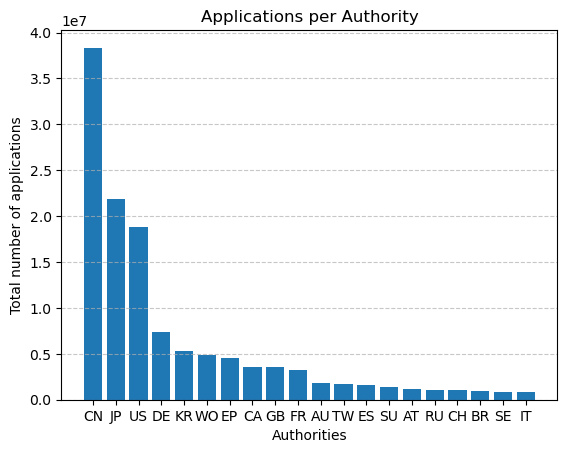

In [8]:
# Import matplotlib.pyplot renaming it as plt
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Define the amounts to be displayed retriving them from the dataframe created in the previous box
authorities = top_auth_df['appln_auth']
tot_applications = top_auth_df['total_applications']

ax.bar(authorities, tot_applications)

# Set axes labels and title of the plot
ax.set_xlabel('Authorities')
ax.set_ylabel('Total number of applications')
ax.set_title('Applications per Authority')

# Draw dot horizontal lines and plot the result
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### APPLN_NR
   This is the actual **application number** assigned by the patent office. This number is often cited in official documentation and used to track the progress of the application. The application number is unique for each application authority.


In [9]:
# Use the query utilized at the beginning of this tutorial but selecting the application number instead of the application id
q = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.appln_nr,
    TLS201_APPLN.appln_auth
).limit(20000)

res_df = patstat.df(q)
res_df

,appln_id,appln_nr,appln_auth
0,930214509,2620848,CN
1,930459598,201301629,ID
2,930377491,0012606240043,EM
3,930402303,88023260002,EM
4,930189467,64315,BG
...,...,...,...
19995,50387582,3775059D,US
19996,50387648,3775095D,US
19997,50418239,3792368D,US
19998,50420664,3793753D,US


Let's say that we are interested in the European applications only. To filter the result, we use the `filter` function.

In [10]:
q = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.appln_nr,
    TLS201_APPLN.appln_auth
).filter(
    TLS201_APPLN.appln_auth == 'EP',  # Filter the result selecting only applications filed at the EPO
    TLS201_APPLN.appln_id <= 900000000
)

res_df = patstat.df(q)
res_df

,appln_id,appln_nr,appln_auth
0,16438496,79301815,EP
1,16459639,80890139,EP
2,16460420,80900934,EP
3,16464653,81103062,EP
4,16470865,81109648,EP
...,...,...,...
4314601,570597719,22714968,EP
4314602,576503831,22738915,EP
4314603,577346431,22745738,EP
4314604,570695479,22305455,EP


As we can see, the only value under the column `appln_auth` is 'EP', indicating that the application numbers in this table refer to applications filed at the EPO, as we requested.

#### Uniqueness of the application number

After this mathematical theorem title, let's demonstrate that the application number is unique for each application authority. There are a few ways to do so. Here it is shown one of them. Specifically, the claim says that each indivual application, identified by its application ID, has a total of application number that amounts to 1 for each application authority. This is to say that if we `count` the number of distinct `appln_nr` for each application authority, i.e. we use a `group_by` on `appl_auth`, we find that each individual application has exactly one application number associated with each of the application authorities where it was filed.

In [11]:
q = db.query(
    TLS201_APPLN.appln_id,
    func.count(TLS201_APPLN.appln_nr).label('tot_appln_nr_associated'),
    TLS201_APPLN.appln_auth
).filter(
    TLS201_APPLN.appln_auth == 'EP',
    TLS201_APPLN.appln_id <= 900000000
).group_by(TLS201_APPLN.appln_id,
           TLS201_APPLN.appln_auth)

res_df = patstat.df(q)
res_df

,appln_id,tot_appln_nr_associated,appln_auth
0,16870888,1,EP
1,17137678,1,EP
2,17195711,1,EP
3,55841444,1,EP
4,57428504,1,EP
...,...,...,...
4314601,425115901,1,EP
4314602,470968733,1,EP
4314603,491736281,1,EP
4314604,520336437,1,EP


Try to remove the filter on the application authority to check that the claim holds in general for each application authority.

There are many rows and most of them are hidden so we have no guarantee that everything is correct in middle of the table too. However, this can be checked out quickly. We simply have to sum along the `tot_appln_nr_associated` and verify that the resulting number is equal to the last index plus 1. Another way to do so is to order by the attribute that we want to check. This second method will be used in the rest of this tutorial.

In [12]:
# Select the tot_appln_nr_associated column from the res_df dataframe and use the sum() Pandas function
check_num = res_df['tot_appln_nr_associated'].sum()
check_num
print("The obtained result is "+str(check_num)+", that is indeed equal to "+str(check_num - 1)+" (last index number) + 1")

The obtained result is 4314606, that is indeed equal to 4314605 (last index number) + 1


This proofs that the sentence claimed at the beginning of this section holds true.

Notice that the vice versa is not true.

In [4]:
qu = db.query(
    TLS201_APPLN.appln_auth,
    TLS201_APPLN.appln_nr,
    func.count(TLS201_APPLN.appln_id).label('count_appln_nr')
).filter(
    TLS201_APPLN.appln_id <= 900000000
).group_by(
    TLS201_APPLN.appln_auth,
    TLS201_APPLN.appln_nr
).having(
    func.count(TLS201_APPLN.appln_id) > 1
).order_by(
    func.count(TLS201_APPLN.appln_id)
)
 
duplicates = patstat.df(qu)
duplicates

,appln_auth,appln_nr,count_appln_nr
0,US,25043D,2
1,CA,83915,2
2,ES,90254,2
3,ES,135619,2
4,DE,D0004728,2
...,...,...,...
6576354,WO,2010000001,71
6576355,WO,2009000001,73
6576356,WO,2016000001,73
6576357,WO,2012000001,76


A clarification on this point. The high numbers of duplicates of `appln_nr` have 'WO' as `appln_auth`, meaning that they are PCT application filed in different national authorities (more details on this topic later on in this course). Nevertheless, this also can happen for some national authorities. However, there is no need to check the date to understand that they are very old applications. For example, the `appln_auth` 'DD' is East Germany.

### APPLN_NR_EPODOC / APPLN_NR_ORIGINAL
These are alternative versions of the application number. The **EPODOC** format is standardized by the EPO and contains digits and letters, whereas the **original number** is the exact form in which it was submitted to the patent office.

So we have several numbers to identify applications in the database. Are them equivalent? The hope is that they are not, otherwise it means that the information contained in the database is redundant. Are all of them reliable in the same way? This is to say, can we use whatever standard we prefer to search in the database? Also, do all the applications have each of the different numbers associated to them? Let's perform an analysis to answer to these questions.

#### Only dummy and artificial applications do not have an appln_nr_epodoc

We start searching for applications without an EPODOC number, i.e. the ones having an empty string for the attribute `appln_nr_epodoc`. For all artificial applications the attribute `appln_nr_epodoc` will contain an empty string, hence we filter out such applications.

In [15]:
no_epodoc = db.query(
    TLS201_APPLN.appln_auth,
    func.count(TLS201_APPLN.appln_id).label('no_epodoc')  # Count the applications with no epodoc number
).filter(
    TLS201_APPLN.appln_nr_epodoc == '',  # Filter according to our search
    TLS201_APPLN.appln_id != 0,
    TLS201_APPLN.appln_id <= 900000000
).group_by(
    TLS201_APPLN.appln_auth
).order_by(
    func.count(TLS201_APPLN.appln_id).desc()  
)

no_epodoc_df = patstat.df(no_epodoc)
print("There are "+str(len(no_epodoc_df))+" applications without EPODOC number")

There are 0 applications without EPODOC number


Let's see if the `appln_nr_epodoc` is unique for `appln_id` and `appln_auth`.

In [16]:
qu_epod = db.query(
    TLS201_APPLN.appln_auth,
    TLS201_APPLN.appln_nr_epodoc,
    func.count(TLS201_APPLN.appln_id).label('count_nr_epodoc')
).filter(
    TLS201_APPLN.appln_id != 0,
    TLS201_APPLN.appln_id <= 900000000
).group_by(
    TLS201_APPLN.appln_auth,
    TLS201_APPLN.appln_nr_epodoc
).having(
    func.count(TLS201_APPLN.appln_id) > 1
).order_by(
    func.count(TLS201_APPLN.appln_id)
)
 
unique = patstat.df(qu_epod)
unique

,appln_auth,appln_nr_epodoc,count_nr_epodoc
0,GB,GB20190018778,2
1,AU,AU19950026801,2
2,IT,IT19840004840,2
3,AU,AU19940078401,2
4,AU,AU19880011801,2
...,...,...,...
8939,AU,AU20160000802,4
8940,AU,AU20120000902,4
8941,AU,AU20140000002,4
8942,AU,AU20150000402,4


The number in `appln_nr_epodoc` is almost unique. For technical reasons, there are almost nine thousand applications with non-unique values in `appln_nr_epodoc`.

#### Some applications do not have an appln_nr_original

For all artificial applications the attribute `appln_nr_original` will contain an empty string. Therefore, let's just filter out artificial applications.

In [17]:
no_original = db.query(
    TLS201_APPLN.appln_auth,
    func.count(TLS201_APPLN.appln_id).label('no_original')
).filter(
    TLS201_APPLN.appln_nr_original == '',
    TLS201_APPLN.appln_id != 0,
    TLS201_APPLN.appln_id <= 900000000  # Filter out artificial applications
).group_by(
    TLS201_APPLN.appln_auth
).order_by(
    func.count(TLS201_APPLN.appln_id).desc()
)

no_original_df = patstat.df(no_original)
no_original_df

,appln_auth,no_original
0,DE,1339760
1,US,783425
2,FR,773915
3,JP,579685
4,BE,427191
...,...,...
94,EE,1
95,MO,1
96,ME,1
97,TN,1


The numbers observed are not negligible. However, what we really mind the most is the percentage of applications with number missing, over the total number of applications filed in each authority.

#### Size of the problem

In [18]:
# Start with computing the total number of applications filed in each authority
total = db.query(
    TLS201_APPLN.appln_auth,
    func.count(TLS201_APPLN.appln_id).label('total')
).group_by(
    TLS201_APPLN.appln_auth
).order_by(
    func.count(TLS201_APPLN.appln_id).desc()
)

# Create subqueries from the previous queries from which retrieve and put together the data needed
no_original_sub = no_original.subquery()
total_sub = total.subquery()

# Compute the percentages over the total number of applications for each application authority
overall = db.query(
    total_sub.c.appln_auth,
    (100 * no_original_sub.c.no_original / total_sub.c.total).label('no_original')
).filter(
    total_sub.c.appln_auth == no_original_sub.c.appln_auth
).order_by(
    (100 * no_original_sub.c.no_original / total_sub.c.total).desc()
)

overall_df = patstat.df(overall)
overall_df['no_original'] = overall_df['no_original'].astype(int)
overall_df

,appln_auth,no_original
0,SM,99
1,DZ,91
2,TJ,90
3,GC,80
4,BE,65
...,...,...
94,ME,0
95,SA,0
96,EE,0
97,TN,0


It seems that there are many application authorities with a high percentage of applications without original number.

This does not mean that authorities with a smaller percentage (showed in the previous table) are easily accessible via these numbers. An authority can have a small percentage of applications with original number missing but a high number of applications overall, hence that small percentage may still result in a high number of application without original number.

#### NO APPLN_NR

Let's see if we encounter a similar problem with the application number seen in the previous section.

In [19]:
no_appln_nr = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.appln_auth,
    func.count(TLS201_APPLN.appln_id).label('no_appln_nr')
).filter(
    TLS201_APPLN.appln_nr == ''
).group_by(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.appln_auth
).order_by(
    func.count(TLS201_APPLN.appln_id).desc()
)

no_application_df = patstat.df(no_appln_nr)
no_application_df

,appln_id,appln_auth,no_appln_nr
0,0,XX,1
1,930132237,,1


Over the entire database, we count only 2 applications with application number missing. Furthermore, these are dummy applications, as can be seen looking at the application ID. 

After the analysis in this section, we can conclude that the two most reliable number attribues are `appln_nr` and `appln_nr_epodoc`. The latter is also almost unique. In the Data Catalog there is an erroneous information, that is that `appln_nr_epodoc` is deprecated. This is actually not true. Therefore, we recommend to use `appln_nr_epodoc` to retrive applications from the database.

### APPLN_KIND
   The **kind code** describes the **type of application**. For example, whether it is a standard patent, a utility model, or another form of intellectual property protection. This is typically denoted by a letter (e.g., A1, B1) that specifies the stage or type of document.

 

In the **PATSTAT** database, specifically in the **TLS201_APPLN** table, the field **appln_kind** refers to the **application kind code**, which indicates the type of patent application. These codes are used to specify the legal nature of the application and its processing status. Each country or patent office uses a set of standardized codes to represent various kinds of applications. Here's an overview of the most common types of patent **application kinds**:
 
#### 1. **Utility Patent Applications**:
   - **A**: Standard utility patent applications are typically referred to by the code **A** in many jurisdictions. This is the most common form of application, intended to protect inventions like machines, processes, and compositions of matter.
 
#### 2. **Utility Models**:
   - **U**: This code is used for **utility models** in countries where they are offered. Utility models are similar to utility patents but usually have a shorter duration and less stringent patentability requirements. They are also referred to as "short-term" patents in some regions.
 
#### 3. **Divisional Applications**:
   - **D**: A **divisional application** is filed when the original application contains more than one invention, requiring the applicant to divide it into separate filings. Divisional applications retain the filing date of the parent application, which is critical for patent protection.
 
#### 4. **International (PCT) Applications**:
   - **P**: Under the **Patent Cooperation Treaty (PCT)**, an international application allows an inventor to seek protection in multiple countries by filing a single application. The kind code **P** designates such international filings.
 
#### 5. **Design Patents**:
   - **F**: Some jurisdictions use the **F** kind code to designate **design patents**. These patents protect the ornamental design of an article rather than its function.
 
#### 6. **Provisional Applications**:
   - **R**: Provisional applications (e.g., in the U.S.) allow an inventor to secure a filing date without submitting a full patent claim. These kinds of applications are often used to give the applicant more time to develop the invention while securing the priority date.
 
#### 7. **Continuation and Continuation-in-Part Applications**:
   - **C**: This code refers to **continuation applications**, which allow an inventor to modify or add new claims to an existing application while keeping the original filing date. **Continuation-in-Part (CIP)** applications allow for new matter to be added, unlike a regular continuation.
 
#### 8. **Supplementary Protection Certificates (SPCs)**:
   - **S**: In certain jurisdictions, **S** refers to applications for **SPCs**, which extend the duration of a patent, typically for pharmaceutical and plant protection products, beyond the standard 20 years.
 
#### Why These Codes Matter:
Each of these application kinds reflects a specific legal strategy or procedural step in the patent application process. For example, a divisional application is filed to address situations where the original application claims more than one invention, while a provisional application is a cost-effective way to establish an early filing date.
 
Different patent offices may have variations in the kind codes they use, but they generally follow similar structures defined by **WIPO Standard ST.16**. This standard ensures consistency across countries, helping patent professionals and examiners understand the nature of an application across jurisdictions.
 
These kinds of codes play a crucial role in the lifecycle of a patent, determining how the application is processed, examined, and potentially granted.

Let's explore the `appln_kind` field. We start retrieving three columns: `appln_kind`, `appln_auth` and the count on `appln_id`. We also order the result by application authority.

In [20]:
appln_kinds = db.query(
    func.count(TLS201_APPLN.appln_id).label('tot_applications'),
    TLS201_APPLN.appln_kind,
    TLS201_APPLN.appln_auth
).group_by(
    TLS201_APPLN.appln_kind,
    TLS201_APPLN.appln_auth
).order_by(
    TLS201_APPLN.appln_auth
)

kinds_df = patstat.df(appln_kinds)
kinds_df

,tot_applications,appln_kind,appln_auth
0,1,D2,
1,8,D2,AD
2,7,F,AE
3,1,U,AE
4,77,A,AE
...,...,...,...
907,3,D2,ZM
908,10,D2,ZW
909,1,F,ZW
910,2890,A,ZW


It is clear that there are authorities where several kinds of applications were filed and other authorities with only one or a few kinds. Let's try to detail our analysis focusing on some particular aspects of the database.

For instance, we may be intersted in the number of different application kinds for each application authority. Notice that in order to get the distinct kinds of application we need the `distinct()` function, otherwise we would have a new count each time that the `appln_kind` field changes the value from row to row.

In [21]:
kinds_per_auth = db.query(
    func.count(TLS201_APPLN.appln_kind.distinct()).label('distinct_kinds'),  # Apply the distinct() function in order to avoid repeated counting
    TLS201_APPLN.appln_auth
).group_by(
    TLS201_APPLN.appln_auth
).order_by(func.count(TLS201_APPLN.appln_kind.distinct()).desc())  # Order by the number of distinct application kinds filed in each authority in descending order so that we can see which are the application authorities with the highest number of distinct application kinds filed

kindsxauth_df = patstat.df(kinds_per_auth)
kindsxauth_df

,distinct_kinds,appln_auth
0,27,DE
1,18,EP
2,17,US
3,16,CN
4,16,SU
...,...,...
202,1,NC
203,1,KW
204,1,GN
205,1,SH


To show that what we are doing is coherent and logical, we sum the values under the column `distinct_kinds`. What we should obtain is the same number of rows of the first table.

In [22]:
total = kindsxauth_df['distinct_kinds'].sum()
total

912

The application authority with the highest number of distinct application kinds is United States. Let's see which kinds of application are filed in the US.

In [23]:
us_kinds = db.query(
    TLS201_APPLN.appln_kind.distinct().label('distinct_kinds'),
    TLS201_APPLN.appln_auth
).filter(TLS201_APPLN.appln_auth == 'US')  # Filter by appln_auth that must be 'US'

us_kinds_df = patstat.df(us_kinds)
us_kinds_df

,distinct_kinds,appln_auth
0,p,US
1,P,US
2,Q,US
3,B2,US
4,A,US
5,F,US
6,D2,US
7,V,US
8,H,US
9,E,US


Now we perform the same analysis for European applications.

In [24]:
eu_kinds = db.query(
    TLS201_APPLN.appln_kind.distinct().label('distinct_kinds'),
    TLS201_APPLN.appln_auth
).filter(TLS201_APPLN.appln_auth == 'EP')  # Filter by appln_auth that must be 'EP'

eu_kinds_df = patstat.df(eu_kinds)
eu_kinds_df

,distinct_kinds,appln_auth
0,B6,EP
1,B1,EP
2,D,EP
3,A1,EP
4,T2,EP
5,U,EP
6,E,EP
7,a,EP
8,A4,EP
9,f,EP


The EPO has two different kinds of application filed.

### APPLN_FILING_DATE
This is one of the most important fields—the **filing date**. It represents the date on which the patent application was filed at the relevant patent office. This date establishes the patent's priority over other filings and is crucial for determining novelty.

Before start any kind of analysis, let's just take a glance of the format of the `appln_filing_date` field. We retrieve the `appln_filing_date` and `appln_auth` attributes. We should expect a huge number of rows.

In [25]:
dates = db.query(
    TLS201_APPLN.appln_filing_date,
    TLS201_APPLN.appln_auth
).order_by(
    TLS201_APPLN.appln_filing_date
).limit(500000)

dates_df = patstat.df(dates)
dates_df

,appln_filing_date,appln_auth
0,1782-07-03,GB
1,1782-07-03,GB
2,1784-08-24,GB
3,1784-08-24,GB
4,1785-04-28,GB
...,...,...
499995,1902-03-05,CA
499996,1902-03-05,FR
499997,1902-03-05,AT
499998,1902-03-05,GB


If we reverse the ordering of the filind date, we can see that there are many applications with year 9999. These are to be intended as missing date.

In [26]:
missing_dates = db.query(
    TLS201_APPLN.appln_filing_date,
    TLS201_APPLN.appln_auth
).order_by(
    TLS201_APPLN.appln_filing_date.desc()
).limit(500000)

missing_dates_df = patstat.df(missing_dates)
missing_dates_df

,appln_filing_date,appln_auth
0,9999-12-31,CA
1,9999-12-31,TW
2,9999-12-31,BE
3,9999-12-31,BE
4,9999-12-31,KR
...,...,...
499995,9999-12-31,US
499996,9999-12-31,US
499997,9999-12-31,SE
499998,9999-12-31,JP


#### Applications filed in the last quarter of 2022 for each application authority

As first exercise, let's see the ranking of the application authorities with the highest number of applications filed in the last quarter of 2022. Since ORM supports boolean operations between dates, we filter the data in order to get the applications filed in dates greater than or equal to 2022-10-01 and smaller than 2022-12-31. It is worth to remark that the words "greater" and "smaller" have a temporal meaning yet they help to build a bridge between the temporal concept and the boolean operations that we are going to use. We import `date` from `datetime`, already installed in TIP. This will enables us to define dates objects, i.e. the two bounding dates.

In [27]:
# Import date from datetime 
from datetime import date

# Define the two bounding dates
start_date = date(2022,10,1)
end_date = date(2022,12,31)

filings = db.query(
    func.count(TLS201_APPLN.appln_id).label('num_of_applications'),
    TLS201_APPLN.appln_auth
).filter(
    TLS201_APPLN.appln_filing_date >= start_date, 
    TLS201_APPLN.appln_filing_date <= end_date  # Filter by filing date via the logical operators 
).group_by(
    TLS201_APPLN.appln_auth
).order_by(func.count(TLS201_APPLN.appln_id).desc())

filings_df = patstat.df(filings)
filings_df

,num_of_applications,appln_auth
0,1101376,CN
1,69890,US
2,60653,WO
3,24228,JP
4,16274,KR
...,...,...
68,1,ID
69,1,IR
70,1,DZ
71,1,PK


This shows a remarkable gap between the first authority, i.e. China, and the following ones.

The `appln_filing_date` attribute is helpful when we are interested in accessing the data referring to some specific quarter dates or range of dates. If we are interested in a particular year or a range of years instead, this can be easily accomplished by querying the `appln_filing_year` field and this nicely introduces the next section.

### APPLN_FILING_YEAR 
This field extracts the **year** from the filing date, making it easier to perform searches or statistical analyses based on the year of application.

#### Number of applications filed at the EPO from 2002 to 2022

We may be interested, for example, in the number of applications filed in EP each year from 2002 to 2022. In order to get this data we can use the same strategy as before, defining a starting and ending dates. This is not complicated yet it can be done in a more straightforward way, that is querying the years in which the applications were filed.

In [28]:
eu_filings_per_year = db.query(
    func.count(TLS201_APPLN.appln_id).label('num_of_applications'),
    TLS201_APPLN.appln_filing_year
).filter(
    TLS201_APPLN.appln_filing_year >= 2002,  # Filtering the years 
    TLS201_APPLN.appln_filing_year <= 2022,
    TLS201_APPLN.appln_auth == 'EP'  # Filtering EP applications
).group_by(TLS201_APPLN.appln_filing_year)

eu_filings_per_year_df = patstat.df(eu_filings_per_year)
eu_filings_per_year_df

,num_of_applications,appln_filing_year
0,159470,2015
1,174958,2019
2,167590,2017
3,155471,2013
4,136565,2009
5,132300,2004
6,79813,2022
7,178875,2020
8,140035,2005
9,171378,2021


Let's visualize it in a bar plot to better grasp the trends of patents applications to the EPO in the last 20 years.

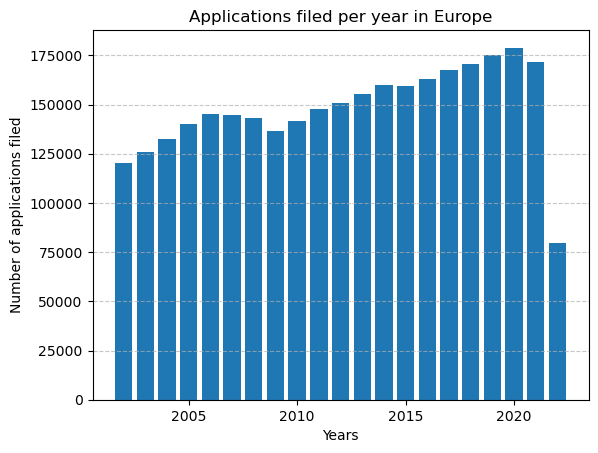

In [29]:
fig, ax = plt.subplots()

# Define the amounts to be displayed retriving them from the dataframe created in the previous box
years = eu_filings_per_year_df['appln_filing_year'] 
applications_filed = eu_filings_per_year_df['num_of_applications']

ax.bar(years, applications_filed)

# Set axes labels and title of the plot
ax.set_xlabel('Years')
ax.set_ylabel('Number of applications filed')
ax.set_title('Applications filed per year in Europe')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### Monthly average number of applications filed at EPO from 2002 to 2022

Now let's move to a trickier exercise. Suppose that we are interested in knowing what is the month with the highest average number of applications filed in the period ranging from 2002 to 2022. Again, we limit the analysis to EP. In this example we see an application of a `subquery`, since we need it in order to carry out the analysis. To access the columns of the table resulting from the inner query we need to import `select`. Moreover, we need the `extract` function in order to select the desired month from the date. In short, the strategy is: counting the applications filed filtering by year and application authority (EP), grouping by month, and then computing the average, grouping again by month. The first part is the subquery. The need for this approach rises since it is not possible to compute aggregate functions of aggregate functions.

In [30]:
from sqlalchemy import extract, select

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dic']

# Inner query (subquery)
monthly_tot = db.query(
    func.count(TLS201_APPLN.appln_id).label('num_of_applications'),
    extract('month', TLS201_APPLN.appln_filing_date).label('month')
).filter(
    TLS201_APPLN.appln_filing_year >= 2002,  
    TLS201_APPLN.appln_filing_year <= 2022,
    TLS201_APPLN.appln_auth == 'EP'  
).group_by(
    extract('month', TLS201_APPLN.appln_filing_date)
).subquery()

# Outer query (notice that the command .c enables to access the columns of the table resulting from the subquery)
monthly_avg = db.query(
    monthly_tot.c.month,
    func.avg(monthly_tot.c.num_of_applications).label('monthly average')
).group_by(monthly_tot.c.month)

monthly_avg_df = patstat.df(monthly_avg)
monthly_avg_df['monthly average'] = monthly_avg_df['monthly average'].astype(int) # Set the type of the average values to integer
monthly_avg_df.index = months # Set the months in letters as index just because it is nice
monthly_avg_df

,month,monthly average
Jan,3,313681
Feb,8,230684
Mar,1,216916
Apr,4,244800
May,7,256477
Jun,5,250545
Jul,12,307418
Aug,11,255897
Sep,2,239351
Oct,9,262469


Below it is the visualization part.

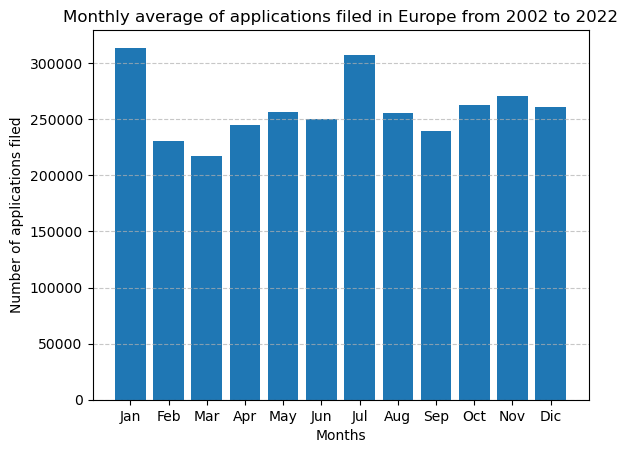

In [31]:
fig, ax = plt.subplots()

# Define the amounts to be displayed retriving them from the dataframe created in the previous box
months = monthly_avg_df.index 
applications_filed = monthly_avg_df['monthly average'].values

ax.bar(months, applications_filed)

# Set axes labels and title of the plot
ax.set_xlabel('Months')
ax.set_ylabel('Number of applications filed')
ax.set_title('Monthly average of applications filed in Europe from 2002 to 2022')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### IPR_TYPE
The **intellectual property right type** defines what kind of protection the application is seeking, such as a patent, utility model, or design patent. Each type offers different scopes of protection.

To get familiar with the intellectual property right types, let's conduct a similar analysis to the one carried out for the application kind.

We start querying the ranking of the application authorities with the highest number of distinct types filed.

In [32]:
ipr_type = db.query(
    func.count(TLS201_APPLN.ipr_type.distinct()).label('num_of_types'),  
    TLS201_APPLN.appln_auth
).group_by(
    TLS201_APPLN.appln_auth
).order_by(func.count(TLS201_APPLN.ipr_type.distinct()).desc())  

ipr_type_df = patstat.df(ipr_type)
ipr_type_df

,num_of_types,appln_auth
0,3,US
1,3,CH
2,3,MY
3,3,BY
4,3,SE
...,...,...
202,1,SZ
203,1,HT
204,1,CW
205,1,MU


Consider the top 2 authorities, i.e. Japan and Taiwan, and show the types of intellectual property right filed there.

In [33]:
jt_kinds = db.query(
    TLS201_APPLN.ipr_type.distinct().label('types'),
    TLS201_APPLN.appln_auth
).filter((TLS201_APPLN.appln_auth == 'JP') | (TLS201_APPLN.appln_auth == 'TW')  # Select the application authorities corresponding to JP or TW (using the | command)
).order_by(TLS201_APPLN.appln_auth)  

jt_kinds_df = patstat.df(jt_kinds)
jt_kinds_df

,types,appln_auth
0,PI,JP
1,UM,JP
2,DP,JP
3,UM,TW
4,DP,TW
5,PI,TW


We do the same for EP. We expect to get only one type of intellectual property right filed at the EPO, i.e. patent.

In [34]:
eu_types = db.query(
    TLS201_APPLN.ipr_type.distinct().label('types'),
    TLS201_APPLN.appln_auth
).filter(TLS201_APPLN.appln_auth == 'EP')  

eu_types_df = patstat.df(eu_types)
eu_types_df

,types,appln_auth
0,DP,EP
1,UM,EP
2,PI,EP


Only one type of intellectual property right filed at the EPO, that, indeed, is patent.

### RECEIVING_OFFICE  
This is the **office** that first received the application. In the case of international applications under the Patent Cooperation Treaty (PCT), this could be a national or regional office acting as the receiving office.

A simple analysis that we can perform is on which is the most frequent receiving office.

In [35]:
rec_off = db.query(
    TLS201_APPLN.receiving_office,
    func.count(TLS201_APPLN.appln_id).label('appln_filed')
).filter(
    TLS201_APPLN.appln_id <= 900000000
).group_by(
    TLS201_APPLN.receiving_office
)

rec_off_df = patstat.df(rec_off)
rec_off_df

,receiving_office,appln_filed
0,ME,3
1,CZ,3229
2,SK,634
3,NL,26488
4,OM,49
...,...,...
108,HR,821
109,PT,1149
110,CU,270
111,MY,3343


The top receiving office is actually an empty string. This point will be covered later on in this section.

Out of curiosity, we can check how many times the EPO results as the receiving office.

In [36]:
ep_rec_off = db.query(
    TLS201_APPLN.receiving_office,
    func.count(TLS201_APPLN.appln_id).label('appln_filed')
).filter(
    TLS201_APPLN.receiving_office == 'EP',
    TLS201_APPLN.appln_id <= 900000000
).group_by(
    TLS201_APPLN.receiving_office
)

ep_rec_off_df = patstat.df(ep_rec_off)
ep_rec_off_df

,receiving_office,appln_filed
0,EP,724705


To show the drastic difference between `appln_auth` and `receiving_office` we display the number of applications for which the two attribuites differ. As we noticed before, there are a lot of applications without a receiving office and these would count as a mismatch with the application authority. We prefer to ignore these cases in our analysis. Please notice that a missing receiving office is identified by a double empty space.

In [37]:
c = db.query(
    TLS201_APPLN.receiving_office,
    TLS201_APPLN.appln_auth
).filter(
    TLS201_APPLN.receiving_office != TLS201_APPLN.appln_auth,
    TLS201_APPLN.receiving_office != '  ',  # Ignore applications without a receiving office, devising double empty spaces
    TLS201_APPLN.appln_id < 900000000
).order_by(
    TLS201_APPLN.appln_auth
)

c_df = patstat.df(c)
c_df

,receiving_office,appln_auth
0,US,WO
1,US,WO
2,US,WO
3,US,WO
4,CH,WO
...,...,...
4793042,CN,WO
4793043,CN,WO
4793044,CN,WO
4793045,CN,WO


In the last query, the result is ordered by `appln_auth` to show that all the applications associated to a receiving office have the WIPO as application authority. Let's repeat this query but filtering the applications without a receiving office instead. This hopefully provides us with an explanation both for this result and that top number of filing observed in the first table of this section.

In [38]:
d = db.query(
    TLS201_APPLN.appln_auth
).filter(
    TLS201_APPLN.receiving_office != TLS201_APPLN.appln_auth,
    TLS201_APPLN.receiving_office == '  ',
    TLS201_APPLN.appln_id < 900000000
).order_by(
    TLS201_APPLN.appln_auth
).limit(500000)

d_df = patstat.df(d)
d_df

,appln_auth
0,AM
1,AM
2,AM
3,AM
4,AM
...,...
499995,AT
499996,AT
499997,AT
499998,AT


Let's check if WIPO is present among the application authorities.

In [39]:
d_subquery = d.subquery()

w = db.query(
    d_subquery.c.appln_auth
).filter(
    d_subquery.c.appln_auth == 'WO'
)

w_df = patstat.df(w)
print("There are "+str(len(w_df))+" applications without receiving office and WIPO as application authority.")

There are 0 applications without receiving office and WIPO as application authority.


This makes sense, since applications without the receiving office are not PCT applications.

### INTERNAT_APPLN_ID
For international applications (those filed under the PCT), this field holds the **unique identifier** for PCT applications assigned by the PATSTAT team.

The default value 0 means this application has no earlier PCT application. If the value of `internat_appln_id` is greater than 0, then this application does have an earlier PCT application, whose `appln_id` equals the value of `internat_appln_id`.

#### Applications with a receiving office

Let's start checking what is the `internat_appln_id` for those applications with a receiving office. Therefore, we filter the application with the `receiving_office` different from the double empty space. We also check the corresponding `appln_auth`.

For computational reasons, we work in 'TEST' in this section.

In [40]:
patstat = PatstatClient(env='TEST')

db = patstat.orm()

In [41]:
internat = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.internat_appln_id,
    TLS201_APPLN.receiving_office,
    TLS201_APPLN.appln_auth
).filter(
    TLS201_APPLN.receiving_office != '  ',
    TLS201_APPLN.appln_id < 900000000
).order_by(
    TLS201_APPLN.internat_appln_id
)

internat_df = patstat.df(internat)
internat_df

,appln_id,internat_appln_id,receiving_office,appln_auth
0,973495,0,AT,WO
1,41851262,0,NL,WO
2,43437960,0,SE,WO
3,46895543,0,US,WO
4,46913024,0,US,WO
...,...,...,...,...
20932,596524674,0,US,WO
20933,597159619,0,US,WO
20934,597707559,0,US,WO
20935,576699090,0,ZA,WO


All of these applications are assigned with an international ID equal to 0 and the corresponding application authority is always the WIPO.

#### Applications without a receiving office

Let's check the opposite case: applications without a receiving office.

In [42]:
internat0 = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.internat_appln_id,
    TLS201_APPLN.appln_auth
).filter(
    TLS201_APPLN.receiving_office == '  ',
    TLS201_APPLN.appln_id < 900000000
).order_by(
    TLS201_APPLN.internat_appln_id
)

internat0_df = patstat.df(internat0)
internat0_df

,appln_id,internat_appln_id,appln_auth
0,23307078,0,GB
1,23307812,0,GB
2,47805262,0,US
3,3150828,0,BE
4,3084616,0,BE
...,...,...,...
302098,267646284,909166996,US
302099,334495749,909167813,US
302100,445918801,909168527,US
302101,325209666,909168667,US


#### International application ID equal to zero

We obtain both international IDs equal to 0 than greater than 0. Let's separate the two cases. We start querying applications with international ID equal to 0.

In [43]:
internat00 = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.internat_appln_id,
    TLS201_APPLN.appln_auth
).filter(
    TLS201_APPLN.internat_appln_id == 0,
    TLS201_APPLN.receiving_office == '  ',
    TLS201_APPLN.appln_id < 900000000
)

internat00_df = patstat.df(internat00)
internat00_df

,appln_id,internat_appln_id,appln_auth
0,23307078,0,GB
1,23307812,0,GB
2,47805262,0,US
3,3150828,0,BE
4,3084616,0,BE
...,...,...,...
254783,604951886,0,KR
254784,604951821,0,KR
254785,605752605,0,KR
254786,605759471,0,KR


We check if the WIPO is present among these application authorities.

In [44]:
sub = internat00.subquery()

res_sub = db.query(
    sub.c.appln_id,
    sub.c.internat_appln_id,
    sub.c.appln_auth
).filter(
    sub.c.appln_auth == 'WO'
)

res_sub_df = patstat.df(res_sub)
print("WO is present "+str(len(res_sub_df))+" times.")

WO is present 0 times.


We can also see that there are applications filed directly to the EPO with no previous PCT applications.

In [45]:
res_sub_ep = db.query(
    sub.c.appln_id,
    sub.c.internat_appln_id,
    sub.c.appln_auth
).filter(
    sub.c.appln_auth == 'EP'
)

res_sub_ep_df = patstat.df(res_sub_ep)
res_sub_ep_df

,appln_id,internat_appln_id,appln_auth
0,16427397,0,EP
1,16427726,0,EP
2,16430987,0,EP
3,16431185,0,EP
4,16431627,0,EP
...,...,...,...
9889,596773199,0,EP
9890,597130083,0,EP
9891,597167063,0,EP
9892,589782537,0,EP


#### Positive international application ID

Now we want to see what is the application authority and the receiving office for those applications with an international ID greater than 0. We expect to not find any receiving office, since a positive international ID means that the application does have a previous PCT application. We also select the application filing date, since it will be useful later on in this section.

In [46]:
pos_internat_id = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.internat_appln_id,
    TLS201_APPLN.receiving_office,
    TLS201_APPLN.appln_auth,
    TLS201_APPLN.appln_filing_date
).filter(
    TLS201_APPLN.internat_appln_id != 0,
    TLS201_APPLN.appln_id < 900000000
).order_by(
    TLS201_APPLN.receiving_office
)

pos_internat_id_df = patstat.df(pos_internat_id)
pos_internat_id_df

,appln_id,internat_appln_id,receiving_office,appln_auth,appln_filing_date
0,50522653,46932129,,US,1982-03-05
1,10530370,46932399,,DE,1980-10-01
2,49371760,47006561,,US,1981-08-17
3,53887677,47006780,,US,1986-05-05
4,2425098,20140159,,AU,1982-10-15
...,...,...,...,...,...
47310,578690114,601604469,,CN,2022-05-05
47311,601176698,604358660,,CN,2022-06-30
47312,596534034,595613605,,KR,2022-08-24
47313,602879973,602333283,,KR,2022-09-26


Ordering by `receiving_office` we are sure that there are not applications with a positive international ID assigned with a receiving office, according to the model adopted in PATSTAT.

In [47]:
pos_internat_id_sub = pos_internat_id.subquery()
    
wo = db.query(
    pos_internat_id_sub.c.appln_id,
    pos_internat_id_sub.c.internat_appln_id,
    pos_internat_id_sub.c.appln_auth
).filter(
    pos_internat_id_sub.c.appln_auth == 'WO'
)

wo_df = patstat.df(wo)
print("The number of applications with positive international ID that have the WIPO as application authority is "+str(len(wo_df)))

The number of applications with positive international ID that have the WIPO as application authority is 0


To prove that our reasoning is correct and the structure of the database is coherent, we search for `appln_id`s in the original table (`TLS201_APPLN`) that are equal to the international IDs that we have just retrived. To do so, we use again the `pos_internat_id` table previously generated as subquery. Moreover, we show the filing dates corresponding to both the first application, linked to the `appln_id`, and the later application, linked to the `internat_appln_id`. We expect these two dates to differ in some cases.

In [48]:
# Retrive all the data from table TLS201_APPLN except for internat_appln_id, retrived from pos_internat_id
ret = db.query(
    TLS201_APPLN.appln_id,
    pos_internat_id_sub.c.internat_appln_id,
    TLS201_APPLN.receiving_office,
    TLS201_APPLN.appln_auth,
    TLS201_APPLN.appln_filing_date.label('application filing date'),  #  Filing date of the application itself
    pos_internat_id_sub.c.appln_filing_date.label('international filing date')  # Filing date of the international application
).filter(
    TLS201_APPLN.appln_id == pos_internat_id_sub.c.internat_appln_id  # Filter searching for appln_id and internat_appln_id matches between the two tables
)

ret_df = patstat.df(ret)
ret_df

,appln_id,internat_appln_id,receiving_office,appln_auth,application filing date,international filing date
0,46969238,46969238,US,WO,1982-07-19,1982-07-19
1,47043977,47043977,US,WO,1986-01-21,1986-01-21
2,47045187,47045187,US,WO,1986-05-19,1988-01-15
3,15654829,15654829,EP,WO,1989-12-12,1989-12-12
4,15656883,15656883,EP,WO,1990-11-30,1992-07-09
...,...,...,...,...,...,...
33086,588076755,588076755,EP,WO,2023-02-21,2023-02-21
33087,573723870,573723870,IB,WO,2022-05-22,2022-05-22
33088,596382310,596382310,JP,WO,2022-01-20,2022-01-20
33089,597223092,597223092,JP,WO,2022-02-10,2022-02-10


Now we can if the opposite can happen, that is finding `appln_id` already associated to a positive `internat_appln_id` that are equal to other international ID. This should not be the case, since positive international ID are associated only to application ID corresponding to first international applications.

In [49]:
rev = db.query(
    pos_internat_id_sub.c.appln_id,
    TLS201_APPLN.internat_appln_id,
    pos_internat_id_sub.c.receiving_office,
    pos_internat_id_sub.c.appln_auth
).filter(
    TLS201_APPLN.internat_appln_id == pos_internat_id_sub.c.appln_id
)

rev_df = patstat.df(rev)
print("The number of applications that match the condition required is "+str(len(rev_df)))

The number of applications that match the condition required is 0


### INT_PHASE, REG_PHASE, NAT_PHASE 
These fields track the **status of the application** in various phases:
- **INT_PHASE**: International phase (for PCT applications, the stage before entering national phases).
- **REG_PHASE**: Regional phase (when an application enters a regional office, like the EPO).
- **NAT_PHASE**: National phase (when a PCT application enters individual countries for patent examination).

To have an overview of these attributes, we can select a specific DOCDB family ID and show some related fields. In the example below, we have applications related to the DOCDB family with ID equal to 23307812. Some of its applications have `internat_appln_id` greater than 0 and blank `receiving_office`, meaning that they are international applications. Indeed, the `int_phase` attribute is set at 'Y'. Other applications have `internat_appln_id` equal to 0. In one case we see that `receiving_office` is 'US' and `appln_auth` is 'WO', meaning that it is an international application and `int_phase` is 'Y' indeed. Notice that `reg_phase` is 'N' and it could not be otherwise, since the receiving office is 'US'. For two other applications, `receiving_office` is blank and `appln_auth` is not 'WO' and `int_phase` is 'N' indeed.

In [3]:
# Go back to PROD
patstat = PatstatClient(env='PROD')

db = patstat.orm()

In [7]:
fam_story = db.query(
    TLS201_APPLN.appln_nr,
    TLS201_APPLN.internat_appln_id,
    TLS201_APPLN.docdb_family_id,
    TLS201_APPLN.receiving_office,
    TLS201_APPLN.appln_auth,
    TLS201_APPLN.int_phase,
    TLS201_APPLN.reg_phase,
    TLS201_APPLN.nat_phase
).filter(
    TLS201_APPLN.appln_id < 900000000,
    TLS201_APPLN.docdb_family_id == 23307812		
)

fam_story_df = patstat.df(fam_story)
fam_story_df 

,appln_nr,internat_appln_id,docdb_family_id,receiving_office,appln_auth,int_phase,reg_phase,nat_phase
0,0009744,0,23307812,US,WO,Y,N,N
1,2001505032,45574554,23307812,,JP,Y,N,Y
2,00922100,45574554,23307812,,EP,Y,Y,N
3,60042329,45574554,23307812,,DE,Y,Y,Y
4,89107574,0,23307812,,TW,N,N,Y
5,33456899,0,23307812,,US,N,N,Y


### EARLIEST_FILING_DATE 
This refers to the **earliest date** on which any priority application linked to this patent was filed. If an application claims priority from an earlier application, this field helps establish that earlier date as the key date for assessing novelty. In particular, this attribute indicates the earliest date of the filing dates of the application itself, its international application, its Paris Convention priority applications, the applications with which it is related via technical relations and its application continuations.

The earliest filing date refers to the date of the first application to be filed among all the different applications belonging to the same DOCDB family. This can be clearly seen retriving the `appln_filing_date` and the `earliest_filing_date` of the applications ordered by `docdb_family_id`. We randomly select one that has more than one application. We see that all the applications belonging to the same DOCDB family have the same earliest filing date.

In [52]:
earl_in_fam = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.appln_nr,
    TLS201_APPLN.docdb_family_id,
    TLS201_APPLN.appln_filing_date,
    TLS201_APPLN.earliest_filing_date
).filter(
    TLS201_APPLN.appln_id < 900000000,
    TLS201_APPLN.docdb_family_id == 63669288	
)

earl_in_fam_df = patstat.df(earl_in_fam)
earl_in_fam_df 

,appln_id,appln_nr,docdb_family_id,appln_filing_date,earliest_filing_date
0,528351961,201916698606,63669288,2019-11-27,2016-05-09
1,506638299,201816143286,63669288,2018-09-26,2016-05-09
2,500778505,201815973341,63669288,2018-05-07,2016-05-09
3,512778702,201816224724,63669288,2018-12-18,2016-05-09
4,506420046,201816143305,63669288,2018-09-26,2016-05-09
...,...,...,...,...,...
102,512776504,201816226566,63669288,2018-12-19,2016-05-09
103,528346584,201916697024,63669288,2019-11-26,2016-05-09
104,511593416,201816230366,63669288,2018-12-21,2016-05-09
105,528345122,201916698668,63669288,2019-11-27,2016-05-09


### EARLIEST_FILING_YEAR
Similar to the field above, this extracts the **year** from the earliest filing date.

Showing the filing year and the earliest filing year, we can see that the two differs in many cases.

In [53]:
earl_fil_year = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.appln_auth,
    TLS201_APPLN.appln_filing_year,
    TLS201_APPLN.earliest_filing_year
).order_by(
    TLS201_APPLN.appln_auth
).limit(500000)

earl_fil_year_df = patstat.df(earl_fil_year)
earl_fil_year_df 

,appln_id,appln_auth,appln_filing_year,earliest_filing_year
0,930132237,,9999,9999
1,930129469,AD,9999,9999
2,930129284,AD,9999,9999
3,930131303,AD,9999,9999
4,930132491,AD,9999,9999
...,...,...,...,...
499995,1013702,AT,2001,2000
499996,319029539,AT,2005,2004
499997,1141405,AT,1983,1982
499998,1176792,AT,1987,1986


### EARLIEST_PUBLN_DATE / EARLIEST_PUBLN_YEAR  
These fields record the **date and year** when the patent was first published. Patent applications are typically published 18 months after the filing date unless the applicant requests early publication or the application is withdrawn before publication.

In [54]:
earl_pub = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.appln_auth,
    TLS201_APPLN.earliest_publn_date,
    TLS201_APPLN.earliest_publn_year
).order_by(
    TLS201_APPLN.appln_auth
).limit(500000)

earl_pub_df = patstat.df(earl_pub)
earl_pub_df 

,appln_id,appln_auth,earliest_publn_date,earliest_publn_year
0,930132237,,9999-12-31,9999
1,930130487,AD,9999-12-31,9999
2,930133292,AD,9999-12-31,9999
3,930131328,AD,9999-12-31,9999
4,930131303,AD,9999-12-31,9999
...,...,...,...,...
499995,900042976,AT,9999-12-31,9999
499996,1018204,AT,2006-09-15,2006
499997,896592,AT,1932-02-25,1932
499998,910116,AT,1935-01-25,1935


### EARLIEST_PAT_PUBLN_ID 
This is the **unique identifier** for the earliest publication of the patent. It links the application to the publication event, which is often the first time the public gets to see the invention.

Let's simply show the ID's together with the earliest filing date and the earliest publication date. Obviously, the publication date is always later than the filing one.

In [55]:
earl_pat_id = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.earliest_pat_publn_id,
    TLS201_APPLN.earliest_filing_date,
    TLS201_APPLN.earliest_publn_date
).filter(
    TLS201_APPLN.appln_id < 900000000
).limit(500000)

earl_pat_id_df = patstat.df(earl_pat_id)
earl_pat_id_df 

,appln_id,earliest_pat_publn_id,earliest_filing_date,earliest_publn_date
0,339864512,383355894,9999-12-31,1869-10-28
1,339865721,383357098,9999-12-31,1872-01-26
2,339866209,383357588,9999-12-31,1872-11-21
3,339867104,383358487,9999-12-31,1873-09-10
4,339867373,383358756,9999-12-31,1874-01-05
...,...,...,...,...
499995,596646454,596646455,2023-03-24,2023-08-04
499996,596357774,596357775,2023-03-24,2023-07-28
499997,604490822,604490823,2023-03-24,2024-01-09
499998,595761508,595761509,2023-03-27,2023-07-18


### GRANTED  
This is a **binary field** that indicates whether the application has been granted (Y for yes, N for no). A granted patent means the application successfully passed the examination phase and the patent office awarded the patent right.

#### Granted patents in 2022 for each application authority

To explore this attribute, an interesting analysis may be looking at the gap between filed applications and granted patents for each application authority in, for example, 2022. We first count the applications filed in 2022 in each application authority, then we use the result as a subquery and from that we compute the number of granted patents, that is filtering the applications with the `granted` attribute equal to 'Y'. Both in the subquery and in the query we need to filter the applications filed in 2022.

In [56]:
# Count the number of applications id for each appication authority in 2022
filed_appln_2022 = db.query(
    TLS201_APPLN.appln_auth,
    func.count(TLS201_APPLN.appln_id).label('filed_applications')
).filter(
    TLS201_APPLN.appln_filing_year == 2022  # Filter the applications filed in 2022
).group_by(
    TLS201_APPLN.appln_auth
).subquery()  # Create subquery

# Count the granted applications
grant_auth_2022 = db.query(
    TLS201_APPLN.appln_auth,
    func.count(TLS201_APPLN.granted).label('granted_patents'),
    filed_appln_2022.c.filed_applications
).filter(
    TLS201_APPLN.granted == 'Y',  # Filter granted applications only
    TLS201_APPLN.appln_filing_year == 2022,  # Again filter applications filed in 2022
    TLS201_APPLN.appln_auth == filed_appln_2022.c.appln_auth
).group_by(
    TLS201_APPLN.appln_auth,
    filed_appln_2022.c.filed_applications
).order_by(
    func.count(TLS201_APPLN.granted).desc()
)

grant_auth_2022_df = patstat.df(grant_auth_2022)
grant_auth_2022_df

,appln_auth,granted_patents,filed_applications
0,CN,2576172,3876190
1,US,89827,376508
2,JP,59413,196156
3,KR,38847,128795
4,TW,29396,57956
5,DE,10639,43396
6,ZA,7816,7959
7,CA,3493,26251
8,EP,2723,79813
9,ES,2429,3147


#### Percentage of granted patents over the total number of filing per application authority in 2022

At this point, we can compute the percentage of granted patents over the total number of filings. Let's create a subquery from the last query so that we can use its attributes to accomplish our computations.

In [57]:
# Generate subquery
subq = grant_auth_2022.subquery()

# Compute the percentages
grant_perc = db.query(
    subq.c.appln_auth,
    (100 * subq.c.granted_patents / subq.c.filed_applications).label('per_granted_pats')
).order_by(
    (100 * subq.c.granted_patents / subq.c.filed_applications).desc()
)

grant_perc_df = patstat.df(grant_perc)
grant_perc_df['per_granted_pats'] = grant_perc_df['per_granted_pats'].astype(int)
grant_perc_df

,appln_auth,per_granted_pats
0,MC,100
1,ZA,98
2,GE,96
3,LU,96
4,BE,92
5,CZ,88
6,NL,87
7,MD,85
8,SA,83
9,SI,82


Again, the percentages must be read in the light of the total number of applications filed. Indeed, the applications authority with 100% of applications granted are the ones with a low number of applications filed.

### DOCDB_FAMILY_ID / INPADOC_FAMILY_ID
These fields represent the **patent family identifiers** in different databases:
- **DOCDB_FAMILY_ID**: The family ID according to the EPO’s DOCDB system, which groups patent applications that are related by common priority claims.
- **INPADOC_FAMILY_ID**: Similar to the DOCDB family but using the INPADOC data from WIPO, which can include additional legal status information.

#### Applications belong to only one DOCDB family

An important concept about DOCDB families is that each patent application in PATSTAT belongs to one and only one DOCDB patent family. To demonstate this fact we can simply count the distinct number of `docbd_family_id`s grouped by `appln_id`.

Again, better to switch to 'TEST'.

In [58]:
patstat = PatstatClient(env='TEST')

db = patstat.orm()

In [59]:
docdb_fam = db.query(
    TLS201_APPLN.appln_id,
    func.count(TLS201_APPLN.docdb_family_id.distinct()).label('dist_docdb_fam')
).group_by(
    TLS201_APPLN.appln_id
).order_by(
    func.count(TLS201_APPLN.docdb_family_id.distinct()).desc()
)

docdb_fam_df = patstat.df(docdb_fam)
docdb_fam_df

,appln_id,dist_docdb_fam
0,23307078,1
1,23307812,1
2,47805262,1
3,3150828,1
4,3084616,1
...,...,...
323703,604951821,1
323704,605752605,1
323705,605759471,1
323706,602886417,1


Ordering by distinct `docdb_family_id` in descending order we get 1 also at the top rows, proving the claim.

Now we show that the vice versa is not true, otherwise the two attributes would provide the same information.

In [60]:
applnxfam = db.query(
    TLS201_APPLN.docdb_family_id,
    func.count(TLS201_APPLN.appln_id.distinct()).label('distinct applications')
).group_by(
    TLS201_APPLN.docdb_family_id
).order_by(
    func.count(TLS201_APPLN.appln_id.distinct()).desc()
)

applnxfam_df = patstat.df(applnxfam)
applnxfam_df

,docdb_family_id,distinct applications
0,47997543,72
1,63669288,59
2,45509505,49
3,34685019,46
4,26009137,44
...,...,...
256865,89511992,1
256866,89511934,1
256867,89714467,1
256868,89714876,1


This property suggests a direct conclusion that affects the modus operandi to follow when performing any kind of analysis concerning the impact of an invention: counting the `appln_id`s grouped by country is counting the number of inventions protected in each country. This is different from counting the `docdb_family_id`s, that results in the actual number of inventions, that is what we really mind when conducting a study on the innovative impact.

For INPADOC families, this is true as well. 

In [61]:
inpadoc_fam = db.query(
    TLS201_APPLN.appln_id,
    func.count(TLS201_APPLN.inpadoc_family_id.distinct()).label('dist_inpadoc_fam')
).group_by(
    TLS201_APPLN.appln_id
).order_by(
    func.count(TLS201_APPLN.inpadoc_family_id.distinct()).desc()
)

inpadoc_fam_df = patstat.df(inpadoc_fam)
inpadoc_fam_df

,appln_id,dist_inpadoc_fam
0,23307078,1
1,23307812,1
2,47805262,1
3,3150828,1
4,3084616,1
...,...,...
323703,604951821,1
323704,605752605,1
323705,605759471,1
323706,602886417,1


#### INPADOC families are bigger than DOCDB families

What does change is the number of applications that an INPADOC family can contain, that is higher than the number of applications included by DOCDB families. This is because INPADOC families comprise applications with related but possibly different technical descriptions, while DOCDB families include applications with identical technical description only. We can also show that for each INPADOC family there is **at least** one DOCDB family associated to it.

In [62]:
applnxinpafam = db.query(
    TLS201_APPLN.inpadoc_family_id,
    func.count(TLS201_APPLN.appln_id.distinct()).label('distinct applications'),
    func.count(TLS201_APPLN.docdb_family_id.distinct()).label('distinct DOCDB families')
).group_by(
    TLS201_APPLN.inpadoc_family_id
).order_by(
    func.count(TLS201_APPLN.docdb_family_id.distinct()).desc()
)

applnxinpafam_df = patstat.df(applnxinpafam)
applnxinpafam_df

,inpadoc_family_id,distinct applications,distinct DOCDB families
0,98645,147,123
1,2715465,89,61
2,318176609,104,40
3,3283,144,39
4,356227,57,36
...,...,...,...
251510,604951886,1,1
251511,604951821,1,1
251512,605752605,1,1
251513,605759471,1,1


### DOCDB_FAMILY_SIZE 
This tells us the **size of the patent family**, meaning how many applications are related through priority claims. A larger family size could indicate that the invention is being pursued in multiple jurisdictions, suggesting its commercial importance.

In [63]:
patstat = PatstatClient(env='PROD')

db = patstat.orm()

In [64]:
size = db.query(
    TLS201_APPLN.docdb_family_id,
    TLS201_APPLN.docdb_family_size
).filter(
    TLS201_APPLN.appln_id < 900000000
).order_by(
    TLS201_APPLN.docdb_family_size
).limit(500000)

size_df = patstat.df(size)
size_df

,docdb_family_id,docdb_family_size
0,24674324,1
1,21777466,1
2,34366971,1
3,40765395,1
4,32918711,1
...,...,...
499995,86836326,1
499996,51121054,1
499997,82667201,1
499998,21951806,1


It is worth to mention that al the artificial applications, i.e. the ones with `appln_id` greater than 900 millions, have the DOCDB family ID equal to `appln_id`.

In [65]:
dummy = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.docdb_family_id
).filter(
    (TLS201_APPLN.appln_id == 0) | (TLS201_APPLN.appln_id > 900000000)
)

dummy_df = patstat.df(dummy)
dummy_df

,appln_id,docdb_family_id
0,900462579,900462579
1,960027498,960027498
2,931406836,931406836
3,900959352,900959352
4,930505777,930505777
...,...,...
11145892,902330624,902330624
11145893,903109253,903109253
11145894,901588152,901588152
11145895,905903456,905903456


### NB_CITING_DOCDB_FAM
This field shows the **number of citing patents** that reference this application’s DOCDB family, indicating the technological relevance or impact of the invention.

#### Total number of citations for application authority

Let's see what is the total number of citations collected in each application authorty.

In [66]:
citing = db.query(
    TLS201_APPLN.appln_auth,
    func.sum(TLS201_APPLN.nb_citing_docdb_fam).label('total_citations')
).group_by(
    TLS201_APPLN.appln_auth
).order_by(
    func.sum(TLS201_APPLN.docdb_family_size).desc()
)

citing_df = patstat.df(citing)
citing_df

,appln_auth,total_citations
0,US,275088682
1,CN,92620335
2,JP,103998470
3,EP,80302676
4,WO,62896429
...,...,...
202,VG,0
203,WS,0
204,MP,0
205,XX,0


#### Average number of citations per DOCDB family for each application authority

This analysis does not keep track of what enabled such authorities to reach these numbers: a few very impactful applications that raised the total number or a generally quite high number of citations for each family related to these authorities? It also depends on the number of families that each authority is associated with. We can investigate this by repeating the same process but computing the average number of citations per application authority instead of the sum.

In [67]:
avg_citing = db.query(
    TLS201_APPLN.appln_auth,
    func.avg(TLS201_APPLN.nb_citing_docdb_fam).label('avg_num_citations')
).group_by(
    TLS201_APPLN.appln_auth
).order_by(
    func.avg(TLS201_APPLN.nb_citing_docdb_fam).desc()
)

avg_citing_df = patstat.df(avg_citing)
avg_citing_df['avg_num_citations'] = avg_citing_df['avg_num_citations'].astype(int)
avg_citing_df

,appln_auth,avg_num_citations
0,ME,40
1,CY,35
2,HK,31
3,DZ,28
4,SV,27
...,...,...
202,CI,0
203,UG,0
204,DM,0
205,SR,0


A statistic at macro level provides meaningful insights only if the total number of samples is high enough. For this reason, we check the total number of DOCDB families to which each application authority is linked.

In [68]:
num_fam = db.query(
    TLS201_APPLN.appln_auth,
    func.count(TLS201_APPLN.docdb_family_id).label('num_docdb_families')
).group_by(
    TLS201_APPLN.appln_auth
).order_by(
    func.count(TLS201_APPLN.docdb_family_id).desc()
)

num_fam_df = patstat.df(num_fam)
num_fam_df

,appln_auth,num_docdb_families
0,CN,38349201
1,JP,21867386
2,US,18865932
3,DE,7396519
4,KR,5360107
...,...,...
202,,1
203,WS,1
204,GQ,1
205,WF,1


#### Median of citations per DOCDB family for each application authority

Nevertheless, the average is not the best statistic that we can use in this context. To explain why, let's imagine a toy example. Suppose that there is an authority with applications filed belonging to two DOCDB families: one is cited a few times, while the other one is cited hundreds of times. The average in this case would be some number in the middle, hence not representative of neither of the two families. To cope with this issue we can use the median instead. Indeed, this value returns the middle number among the ones present in the sample.

Since there is not a command in ORM to directly compute the median, we have to do it manually. To do so, we start counting the number of families to which each application authority is linked. If this number is odd we just take the middle value, otherwise we take the average between the two middle values.

In [69]:
# Count the number of families for each application authority
count_citing = db.query(
    TLS201_APPLN.appln_auth,
    func.count(TLS201_APPLN.docdb_family_id).label('families_count')
).group_by(
    TLS201_APPLN.appln_auth
).order_by(
    func.count(TLS201_APPLN.docdb_family_id)
)

count_citing_df = patstat.df(count_citing)

# Create an empty list that will be filled with the medians of families citations for each authority
medians = []

# Run through the application authorities in the dataframe just created while keeping track of the row index
for (i, auth) in zip(count_citing_df.index, count_citing_df['appln_auth']):
    count = count_citing_df.iloc[i,1]  # count is the variable containing the number of DOCDB families of the current authority auth
    # Check if count is odd or even
    if count % 2 == 1:
        # Odd case: get the middle value
        median_query = db.query(TLS201_APPLN.nb_citing_docdb_fam).filter(TLS201_APPLN.appln_auth == auth).order_by(TLS201_APPLN.nb_citing_docdb_fam).offset(count // 2).limit(1)
        result = median_query.all()
        median_value = result[0][0]
        medians.append(median_value)
    else:
        # Even case: get the two middle values 
        median_query = db.query(TLS201_APPLN.nb_citing_docdb_fam).filter(TLS201_APPLN.appln_auth == auth).order_by(TLS201_APPLN.nb_citing_docdb_fam).offset(count // 2 - 1).limit(2)
        result = median_query.all()
        # Compute the average of the two middle values
        median_value = sum([res[0] for res in result]) / 2.0
        medians.append(median_value)

# Create a dataframe with two columns: the application authorities and the corresponding median values of citations
median_citing_df = pd.DataFrame({'appln_auth': count_citing_df['appln_auth'], 'median_of_citation': medians})
# Convert the median values to integer type
median_citing_df['median_of_citation'] = median_citing_df['median_of_citation'].astype(int)
# Sort by median in descending order (ascending=False)
median_citing_df.sort_values(by='median_of_citation', ascending=False, inplace=True)
# Do not sort the index
median_citing_df = median_citing_df.reset_index(drop=True)
median_citing_df

,appln_auth,median_of_citation
0,ME,20
1,CY,15
2,HK,14
3,DZ,13
4,SV,13
...,...,...
202,XN,0
203,MO,0
204,NG,0
205,PY,0


We do not have such extreme cases as the one in the toy example, hence the numbers observed in the median table are a bit different from the ones in the average table but it does not change the ranking. The evidence here is that these two tables show a different story from the table of total applications. Indeed, we can see that while CN, US, EP and WO are the application authorities with the highest numbers of citations, the highest averages and medians are found in smaller authorities. This tells us a key fact about patents market: when an invention is truly innovative (and supposedly will be cited more times) it will be protected in more countries, even the smallest ones. Conversely, in bigger countries we can find inventions with different level of innovation. This results in small countries collecting less filing and so less citations but quite innovative inventions on average. One can check the size of the most cited families to confirm this hypothesis but this analysis is beyond the scope of this course.

### NB_APPLICANTS / NB_INVENTORS
These fields count the **number of applicants** and **number of inventors** associated with the application. A single application may have multiple inventors or applicants (such as a corporation and its researchers).

If no publication of the application contains applicant names in Latin characters, then `nb_applicants` will be zero. Similarly, if no publication of the application contains inventor names in Latin characters, then `nb_inventors` will be zero.

In PATSTAT quite many applications with either `nb_applicants` or `nb_inventors` equal to 0 can be found. This can be checked with a simple query.

Since these are just illustrative examples, let's work in 'TEST'.

In [70]:
patstat = PatstatClient(env='TEST')

db = patstat.orm()

In [71]:
no_applicant_inv = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.appln_auth,
    TLS201_APPLN.nb_applicants,
    TLS201_APPLN.nb_inventors
).filter(
    (TLS201_APPLN.nb_applicants == 0) | (TLS201_APPLN.nb_inventors == 0),
    TLS201_APPLN.appln_id < 900000000
).order_by(
    TLS201_APPLN.nb_applicants
)

no_applicant_inv_df = patstat.df(no_applicant_inv)
no_applicant_inv_df

,appln_id,appln_auth,nb_applicants,nb_inventors
0,23307078,GB,0,0
1,23307812,GB,0,0
2,47805262,US,0,0
3,3150828,BE,0,0
4,3084616,BE,0,0
...,...,...,...,...
10541,570126409,DE,4,0
10542,557220105,IL,5,0
10543,501706837,DE,9,0
10544,566485039,DE,12,0


Some applications do not have inventors registered, often because they do not want to share their names. What is stranger is to not have any applicants. Yet this can happen.

In [72]:
no_applicant = db.query(
    TLS201_APPLN.appln_id,
    TLS201_APPLN.appln_auth,
    TLS201_APPLN.nb_applicants,
    TLS201_APPLN.nb_inventors
).filter(
    TLS201_APPLN.nb_applicants == 0,
    TLS201_APPLN.nb_inventors != 0,
    TLS201_APPLN.appln_id < 900000000
).order_by(
    TLS201_APPLN.nb_applicants
)

no_applicant_df = patstat.df(no_applicant)
no_applicant_df

,appln_id,appln_auth,nb_applicants,nb_inventors
0,20868306,FR,0,1
1,19351006,FR,0,1
2,19384289,FR,0,3
3,19372853,FR,0,2
4,19381110,FR,0,1
...,...,...,...,...
1918,587515270,CL,0,3
1919,587515278,CL,0,2
1920,592390028,FI,0,3
1921,596542825,TW,0,1


It can also be observed that the number of inventors linked to an application is usually higher than the corresponding number of applicants.

In [73]:
more_appl = db.query(
    func.count(TLS201_APPLN.appln_id).label('occurrencies')
).filter(
    TLS201_APPLN.nb_applicants > TLS201_APPLN.nb_inventors
)

occurrencies = patstat.df(more_appl)
occurrencies = occurrencies['occurrencies'].item()
print("We find "+str(occurrencies)+" applications with more applicants than inventors.")

We find 28135 applications with more applicants than inventors.
